# Power-Law Model: Shear-Thinning Fluid Fitting

Demonstrates Power-Law model fitting to viscosity data showing shear-thinning behavior.

## Learning Objectives

- Fit Power-Law model to viscosity curves
- Understand shear-thinning/thickening behavior
- Interpret flow behavior index (n)
- Bayesian inference for rheological parameters

**Prerequisites:** Basic rheology, complete 01-maxwell-fitting.ipynb

**Estimated Time:** 30-35 minutes

In [ ]:
# Google Colab Setup - Run this cell first!
# Skip if running locally with rheojax already installed

import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Install rheojax and dependencies
    !pip install -q rheojax
    
    # Colab uses float32 by default - we need float64 for numerical stability
    # This MUST be set before importing JAX
    import os
    os.environ['JAX_ENABLE_X64'] = 'true'
    
    print("✓ RheoJAX installed successfully!")
    print("✓ Float64 precision enabled")

## Setup

In [1]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
# Configure matplotlib for inline plotting in VS Code/Jupyter
# MUST come before importing matplotlib
%matplotlib inline

import time
import warnings

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.power_law import PowerLaw
from rheojax.pipeline.base import Pipeline

jax, jnp = safe_import_jax()
verify_float64()
print("✓ JAX float64 enabled")

np.random.seed(42)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

# Suppress matplotlib backend warning in VS Code
warnings.filterwarnings('ignore', message='.*non-interactive.*')


INFO:2025-11-14 08:27:48,353:jax._src.xla_bridge:808: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
Loading rheojax version 0.2.0
/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/piblin_jax/__init__.py:28: UserWarning: GPU acceleration is only available on Linux with CUDA 12+. Using JAX in CPU mode.
  from . import backend, data, dataio, transform


✓ JAX float64 enabled


## Power-Law Theory

The Power-Law (Ostwald-de Waele) model describes non-Newtonian flow:

**Constitutive Equation:**
$$\eta(\dot{\gamma}) = K \dot{\gamma}^{n-1}$$
$$\sigma(\dot{\gamma}) = K \dot{\gamma}^n$$

**Parameters:**
- $K$ = consistency index (Pa·s$^n$) - magnitude of viscosity
- $n$ = flow behavior index:
  - $n < 1$: shear-thinning (most polymers)
  - $n = 1$: Newtonian (constant viscosity)
  - $n > 1$: shear-thickening (rare)

**Applications:** Polymer solutions, ketchup, paints, blood

In [2]:
# True parameters (shear-thinning)
K_true = 5.0   # Pa·s^n
n_true = 0.6   # Shear-thinning

print(f"True Parameters:")
print(f"  K = {K_true:.2f} Pa·s^{n_true}")
print(f"  n = {n_true:.2f} (shear-thinning)")

# Shear rate array
gamma_dot = np.logspace(-1, 3, 40)  # 0.1 to 1000 s⁻¹

# True viscosity
eta_true = K_true * gamma_dot**(n_true - 1)

# Add noise
noise_level = 0.02
noise = np.random.normal(0, noise_level * eta_true)
eta_noisy = eta_true + noise

print(f"\nData: {len(gamma_dot)} points")
print(f"Viscosity range: {eta_noisy.min():.3f} - {eta_noisy.max():.3f} Pa·s")

True Parameters:
  K = 5.00 Pa·s^0.6
  n = 0.60 (shear-thinning)

Data: 40 points
Viscosity range: 0.317 - 12.684 Pa·s


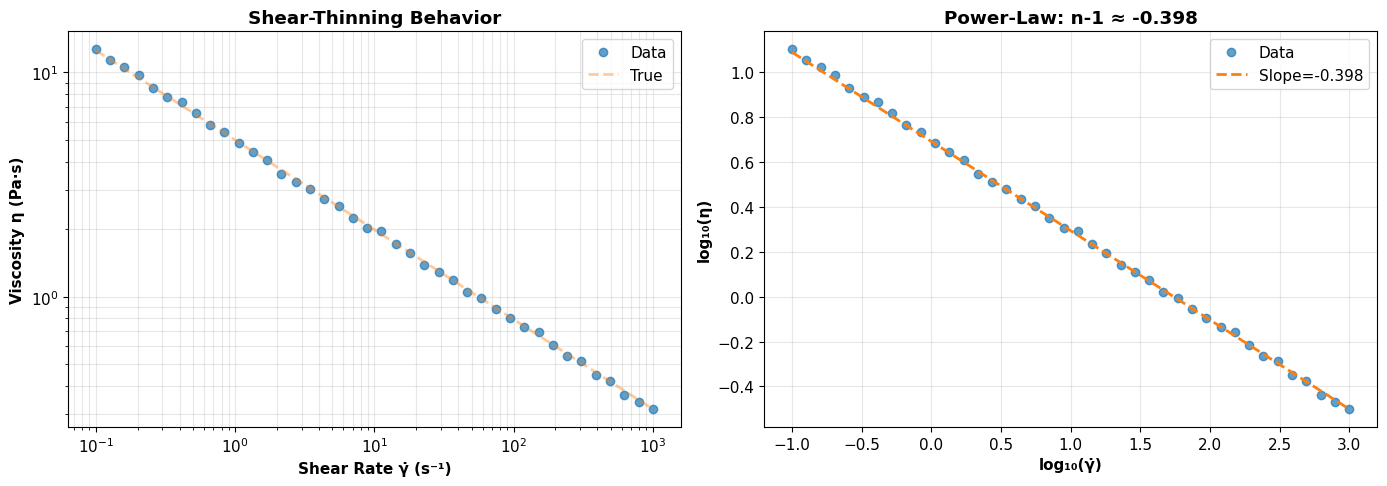


Estimated n from slope: 0.602 (true: 0.600)


In [3]:
# Visualize shear-thinning
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.loglog(gamma_dot, eta_noisy, 'o', alpha=0.7, label='Data')
ax1.loglog(gamma_dot, eta_true, '--', linewidth=2, alpha=0.4, label='True')
ax1.set_xlabel('Shear Rate γ̇ (s⁻¹)', fontweight='bold')
ax1.set_ylabel('Viscosity η (Pa·s)', fontweight='bold')
ax1.set_title('Shear-Thinning Behavior', fontweight='bold')
ax1.grid(True, alpha=0.3, which='both')
ax1.legend()

# Log-log slope = n-1
log_gd = np.log10(gamma_dot)
log_eta = np.log10(eta_noisy)
slope = np.polyfit(log_gd[10:30], log_eta[10:30], 1)[0]
ax2.plot(log_gd, log_eta, 'o', alpha=0.7, label='Data')
ax2.plot(log_gd, np.polyval([slope, np.polyfit(log_gd[10:30], log_eta[10:30], 1)[1]], log_gd), '--', linewidth=2, label=f'Slope={slope:.3f}')
ax2.set_xlabel('log₁₀(γ̇)', fontweight='bold')
ax2.set_ylabel('log₁₀(η)', fontweight='bold')
ax2.set_title(f'Power-Law: n-1 ≈ {slope:.3f}', fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
display(fig)
plt.close(fig)

print(f"\nEstimated n from slope: {slope+1:.3f} (true: {n_true:.3f})")


## Fitting (Log-Log Linear Regression)

In [4]:
model = PowerLaw()
model.fit(gamma_dot, eta_noisy)

K_fit = model.parameters.get_value('K')
n_fit = model.parameters.get_value('n')

print("="*60)
print("FITTED PARAMETERS")
print("="*60)
print(f"K = {K_fit:.3f} Pa·s^n (true: {K_true:.3f})")
print(f"n = {n_fit:.4f} (true: {n_true:.4f})")
print(f"\nErrors: K {abs(K_fit-K_true)/K_true*100:.2f}%, n {abs(n_fit-n_true)/n_true*100:.2f}%")
print(f"\nBehavior: {'Shear-thinning' if n_fit < 1 else 'Shear-thickening' if n_fit > 1 else 'Newtonian'}")
print("="*60)

FITTED PARAMETERS
K = 4.997 Pa·s^n (true: 5.000)
n = 0.5983 (true: 0.6000)

Errors: K 0.06%, n 0.29%

Behavior: Shear-thinning


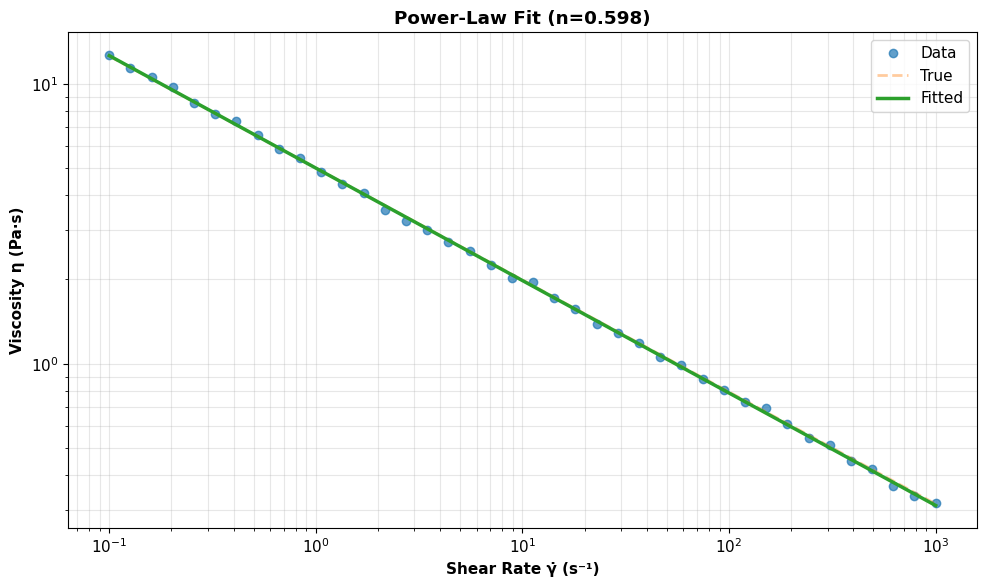

R² = 0.999544


In [5]:
# Visualize fit
eta_pred = model.predict(gamma_dot)

fig = plt.figure(figsize=(10, 6))
plt.loglog(gamma_dot, eta_noisy, 'o', alpha=0.7, label='Data')
plt.loglog(gamma_dot, eta_true, '--', linewidth=2, alpha=0.4, label='True')
plt.loglog(gamma_dot, eta_pred, '-', linewidth=2.5, label='Fitted')
plt.xlabel('Shear Rate γ̇ (s⁻¹)', fontweight='bold')
plt.ylabel('Viscosity η (Pa·s)', fontweight='bold')
plt.title(f'Power-Law Fit (n={n_fit:.3f})', fontweight='bold')
plt.grid(True, alpha=0.3, which='both')
plt.legend()
plt.tight_layout()
display(fig)
plt.close(fig)

r2 = 1 - np.sum((eta_noisy - eta_pred)**2) / np.sum((eta_noisy - np.mean(eta_noisy))**2)
print(f"R² = {r2:.6f}")


## Bayesian Inference

In [6]:
print("Running Bayesian inference...\n")

result = model.fit_bayesian(
    gamma_dot, eta_noisy,
    num_warmup=1000,
    num_samples=2000,
    num_chains=1,
    initial_values={'K': K_fit, 'n': n_fit}
)

print("Complete!")

Running Bayesian inference...



sample: 100%|██████████| 3000/3000 [00:01<00:00, 2256.59it/s, 3 steps of size 4.57e-01. acc. prob=0.90] 

Complete!


In [7]:
summary = result.summary
diagnostics = result.diagnostics
credible = model.get_credible_intervals(result.posterior_samples, 0.95)

print("="*60)
print("POSTERIOR SUMMARY")
print("="*60)
print(f"\nK = {summary['K']['mean']:.3f} ± {summary['K']['std']:.3f} Pa·s^n")
print(f"n = {summary['n']['mean']:.4f} ± {summary['n']['std']:.4f}")
print(f"\n95% CI K: [{credible['K'][0]:.3f}, {credible['K'][1]:.3f}]")
print(f"95% CI n: [{credible['n'][0]:.4f}, {credible['n'][1]:.4f}]")
print(f"\nR-hat: K={diagnostics['r_hat']['K']:.4f}, n={diagnostics['r_hat']['n']:.4f}")
print(f"ESS: K={diagnostics['ess']['K']:.0f}, n={diagnostics['ess']['n']:.0f}")
print("="*60)

# Check if credible interval confirms shear-thinning
if credible['n'][1] < 1:
    print("\n✓ Shear-thinning confirmed (95% CI n < 1)")
elif credible['n'][0] > 1:
    print("\n✓ Shear-thickening confirmed (95% CI n > 1)")
else:
    print("\n⚠ Behavior uncertain (95% CI includes n=1)")

POSTERIOR SUMMARY

K = 5.001 ± 0.017 Pa·s^n
n = 0.5954 ± 0.0019

95% CI K: [4.969, 5.035]
95% CI n: [0.5918, 0.5992]

R-hat: K=1.0000, n=1.0000
ESS: K=2000, n=2000

✓ Shear-thinning confirmed (95% CI n < 1)


## Key Takeaways

1. **Flow Behavior Index n:**
   - n < 1: Viscosity decreases with shear rate (shear-thinning)
   - Most polymer solutions are shear-thinning (0.2 < n < 0.8)

2. **Consistency Index K:**
   - Sets overall viscosity magnitude
   - Temperature dependent (higher T → lower K)

3. **Bayesian Uncertainty:**
   - Quantifies uncertainty in flow behavior
   - Can confirm shear-thinning/thickening statistically

## Next Steps

- **[04-bingham-fitting.ipynb](04-bingham-fitting.ipynb)**: Yield stress fluids
- **[transforms/02-mastercurve-generation.ipynb](../transforms/02-mastercurve-generation.ipynb)**: Temperature effects
- **[bayesian/04-model-comparison.ipynb](../bayesian/04-model-comparison.ipynb)**: Compare flow models

In [8]:
import sys

import rheojax

print(f"Python: {sys.version}")
print(f"Rheo: {rheojax.__version__}")

Python: 3.13.9 (main, Oct 14 2025, 21:10:40) [Clang 20.1.4 ]
Rheo: 0.2.0
